In [ ]:
# Mounting the drive to upload images 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if we are using the right processor
!nvidia-smi

Fri Apr 28 12:34:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Creating an environment to download our weights and use them later
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-aiqhcute
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-aiqhcute
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=4b8f4476b65ff36785e72098fa1ae36689802f5a3f94c01d1afe07d7780f96a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kadzd8q/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
# Installing the requirements
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.9 MB/s eta 0:00:00


In [ ]:
# Downloading the weights
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
# Loading the model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
# If you don't have segment anything library just pip install it

In [ ]:
# Loading a mask for SAM
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

# The path to your image on drive 
IMAGE_PATH = ('/content/drive/MyDrive/Img_for_segmentation/Trans/AT15_GRE15_trans_14022023-161427.jpg')

In [ ]:
# Generating the mask 

import cv2
import supervision as sv

# Loading the image
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb,(640,480))
image_bgr = image_rgb
sam_result = mask_generator.generate(image_rgb)

In [ ]:
# SamAutomaticMaskGenerator returns a list of masks, where each mask is a dict containing various information about the mask:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


<class 'numpy.ndarray'>


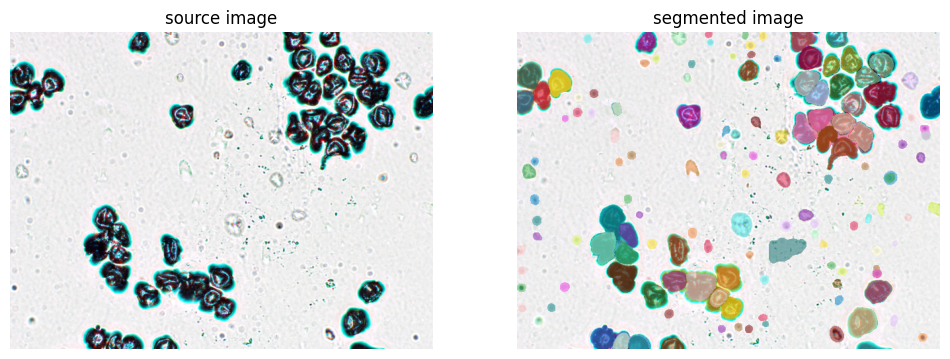

In [ ]:
# Results visualisation with Supervision
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
print(type(annotated_image))
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)
# Result should be the original image VS the segmented image

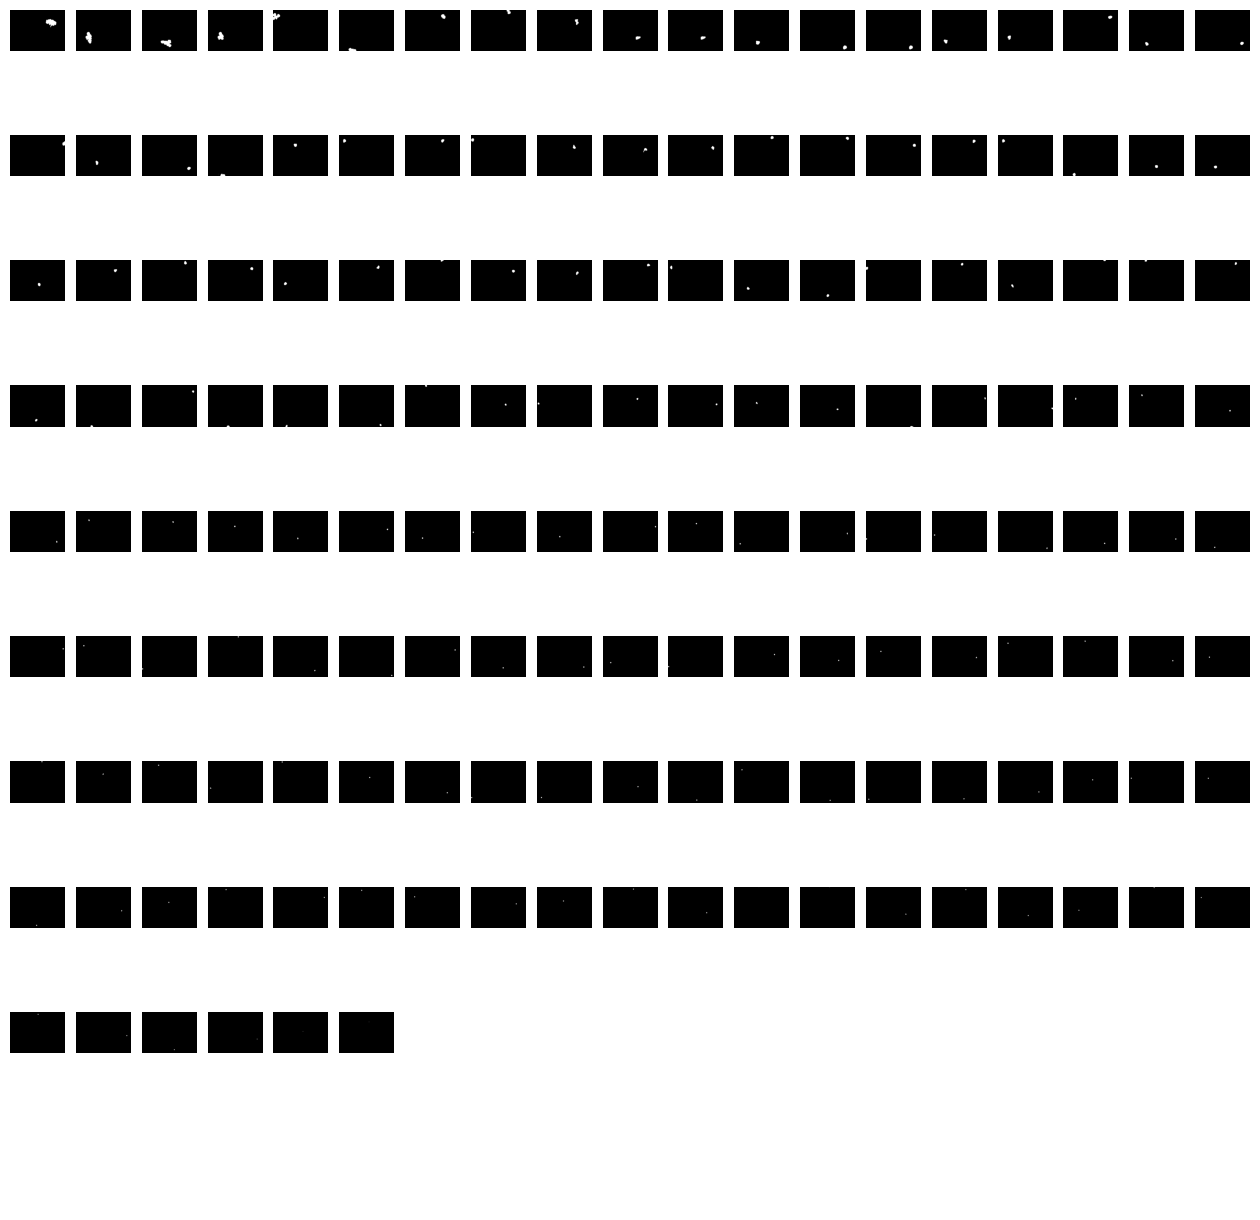

In [ ]:
# In this part you wil get the mask for the image 
import matplotlib.pyplot as plt
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]
# print(type(masks[0]))
# plt.imshow(masks[0])
#plt.imshow(masks[6])
sv.plot_images_grid(
    images=masks,
    grid_size=(10, int(len(masks) / 8)),
    size=(16, 16)
)

  
# You will see some duplicates in this part, this is because SAM expects ambiguity and allows you to pick the right mask.

307200
6119
6091
4433
4020
2221
1975
1956
1769
1609
1608
1607
1579
1536
1463
1368
1328
1199
1170
1156
1151
1112
1111
1103
1068
1030
1027
1021
1019
997
993
984
979
971
953
949
943
940
934
920
918
917
878
875
849
838
816
803
794
750
740
719
680
663
636
629
616
595
501
(480, 640)
58.0


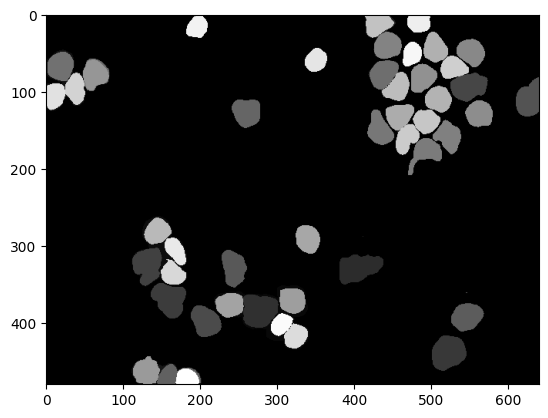

In [ ]:
import cv2
import numpy as np
import random
# Load the original image and masks
image = image_bgr

# Create an empty image and fill it with a background color
combined_image = np.zeros((480, 640))

for i, mask in enumerate(masks):
    if np.sum(mask)>500 and np.sum(mask)<7000:
      color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))  # Generate a random RGB color
      combined_image[mask != 0] = i
      nth_label = np.where(combined_image == i, 1, 0)
      print(np.sum(nth_label))
print(combined_image.shape)
# Save the combined image
plt.imsave('/content/drive/MyDrive/Physiozoo/combined_img.png', combined_image)
print(np.max(combined_image))
plt.imshow(combined_image,cmap = 'gray')

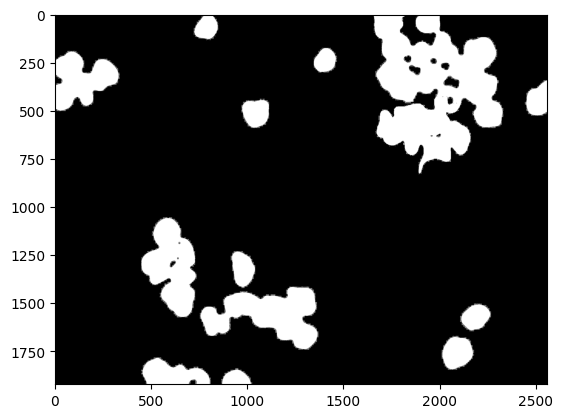

In [ ]:
import cv2
import numpy as np

# Load the two segmented images
img1 = combined_image
img2 = cv2.imread('/content/drive/MyDrive/Labels 12096947.0.jpg', cv2.IMREAD_GRAYSCALE)
img2 = np.where(img2>0, 1, 0)

plt.imshow(img2, cmap = 'gray')

# Create a binary mask for each image
mask1 = (img1 > 0).astype(np.uint8)
mask2 = (img2 > 0).astype(np.uint8)

for j in range(8, int(np.max(img1))):
  mask = np.where(img1 == j, 1, 0)
  len = np.sum(mask)
  # plt.figure()
  # plt.imshow(mask, cmap = 'gray')

  intersection = np.logical_and(mask, img2)
  iou = np.sum(intersection)/ len

  print(f"IoU: {iou}")





# # Compute the intersection and union between the masks
# intersection = np.logical_and(mask1, mask2)
# union = np.logical_or(mask1, mask2)

# # Compute the IoU
# iou = np.sum(intersection) / np.sum(union)
# print(f"IoU: {iou}")


1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
IoU: 0.14988191824921956


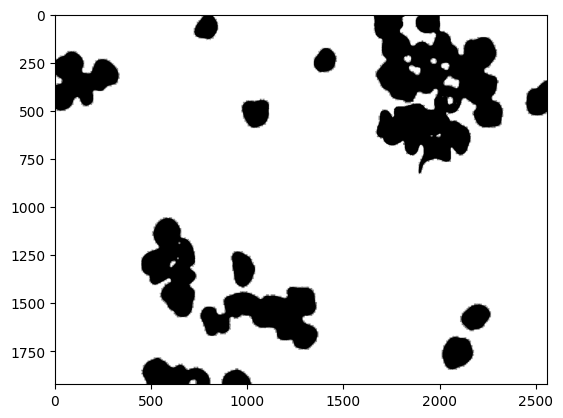

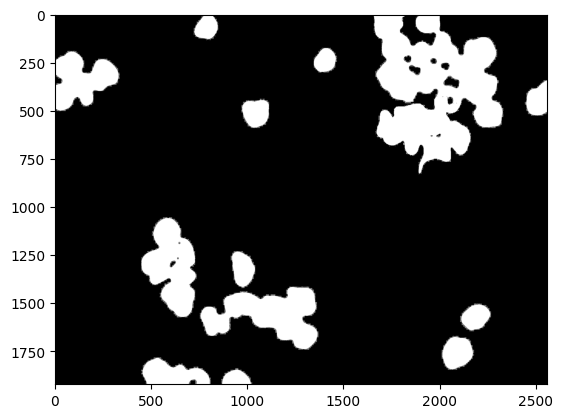

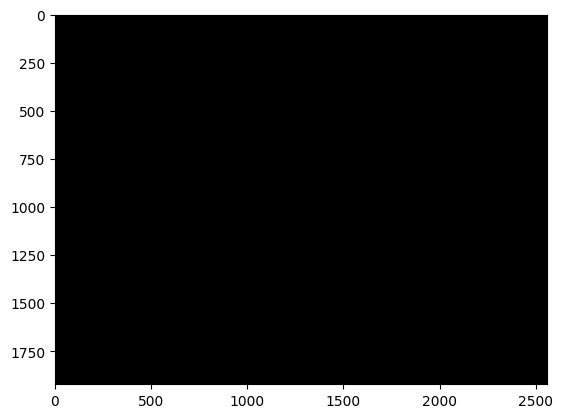

In [ ]:
import cv2
import numpy as np

# Load the two segmented images
img1 = cv2.imread('/content/drive/MyDrive/Physiozoo/combined_img.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/drive/MyDrive/Labels 12096947.0.jpg', cv2.IMREAD_GRAYSCALE)
img2 = (img2 > 0).astype(np.uint8)
print(np.max(img2))
print(img2)
plt.imshow(img2, cmap = 'binary')
# Create a binary mask for each image
mask1 = (img1 > 0).astype(np.uint8)
mask2 = (img2 > 0).astype(np.uint8)

# Compute the intersection and union between the masks
intersection = np.logical_and(mask1, mask2).astype(np.uint8)
union = np.logical_or(mask1, mask2).astype(np.uint8)

plt.figure()
plt.imshow(intersection, cmap = 'gray')
plt.figure()

plt.imshow(union, cmap = 'gray')
print(union)

# Compute the IoU
iou = np.sum(intersection) / np.sum(union)
print(f"IoU: {iou}")
